## Google Colab Only - Download Source Code and Data

The download code is hosted on GitHub Pages, since we need to keep parts of the code private. If the download links doesn't work, please contact hy.gui@mail.utoronto.ca

In [ ]:
import os


def download_data(re_download: bool = False):
    if not re_download and os.path.isdir('Data'):
        print('Data exists, skipping download...')
        return

    if not os.path.isfile('data-p3.tar.zst'):
        !wget -O data.tar.zst "https://hydevelop-my.sharepoint.com/:u:/g/personal/me_hydev_org/EYKTKk0t2F9CugSY35Wk2ZMBRkBzQOJZMvkjVjkEK71g3w?download=1" -q --show-progress

    !echo 'Installing ZSTD'
    !apt update > apt.log 2>/dev/null && apt install gzip zstd pv -y >> apt.log 2>/dev/null && \
            echo 'ZSTD Installed Successfully' || echo 'ZSTD Install Failed (check apt.log)'

    !echo 'Extracting...'
    # !pv data.tar.zst -f | tar -I zstd -x
    !tar -I zstd -x -f data.tar.zst --checkpoint=.4096 --totals


download_data(True)

# Prepare Environment

In [1]:
!pip install nltk~=3.7 gensim~=4.1.2 scikit-learn~=1.0.2 textblob~=0.17.1 matplotlib~=3.5.1 seaborn~=0.11.2 wordcloud~=1.8.1 missingno~=0.5.1 numpy~=1.21.6 xgboost~=1.6.0 -q

In [2]:
from __future__ import annotations

import os
import warnings

import pandas as pd

warnings.filterwarnings('ignore')

# Data Preprocessing & NLP
import nltk
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer

from utils import *

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/azalea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/azalea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/azalea/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 0. Preprocessing

### 0.1. Preprocess Fucntions

In [7]:
import unicodedata
import nltk
import string
from nltk.corpus import stopwords


STOPWORDS = stopwords.words('english')
TOK = nltk.tokenize.toktok.ToktokTokenizer()
PORTER_STEMMER = nltk.porter.PorterStemmer()
WHITELIST = string.digits + string.whitespace + string.ascii_letters


def remove_punctuation(text: str) -> str:
    # Replace accented chars with normal form
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').strip()

    # Remove double space
    while '  ' in text:
        text = text.replace('  ', ' ')

    # Keep only A-Z, a-z, 0-9, space
    return ''.join(c for c in text if c in WHITELIST)


def remove_stopwords(text: str) -> str:
    tokens = [t.strip() for t in TOK.tokenize(text.lower())]
    return ' '.join(t for t in tokens if t not in STOPWORDS)


def stem(text: str) -> str:
    return ' '.join([PORTER_STEMMER.stem(word) for word in text.split()])


def preprocess(text: str) -> str:
    return stem(remove_stopwords(remove_punctuation(text)))

### 0.2. Load reviews and preprocess

In [4]:
dataset = pd.read_csv('Data/reviews.csv', encoding='ISO-8859-1')
dataset['reviewTextProc'] = dataset['reviewText'].apply(preprocess)

### 0.3 Wordcloud Visualization

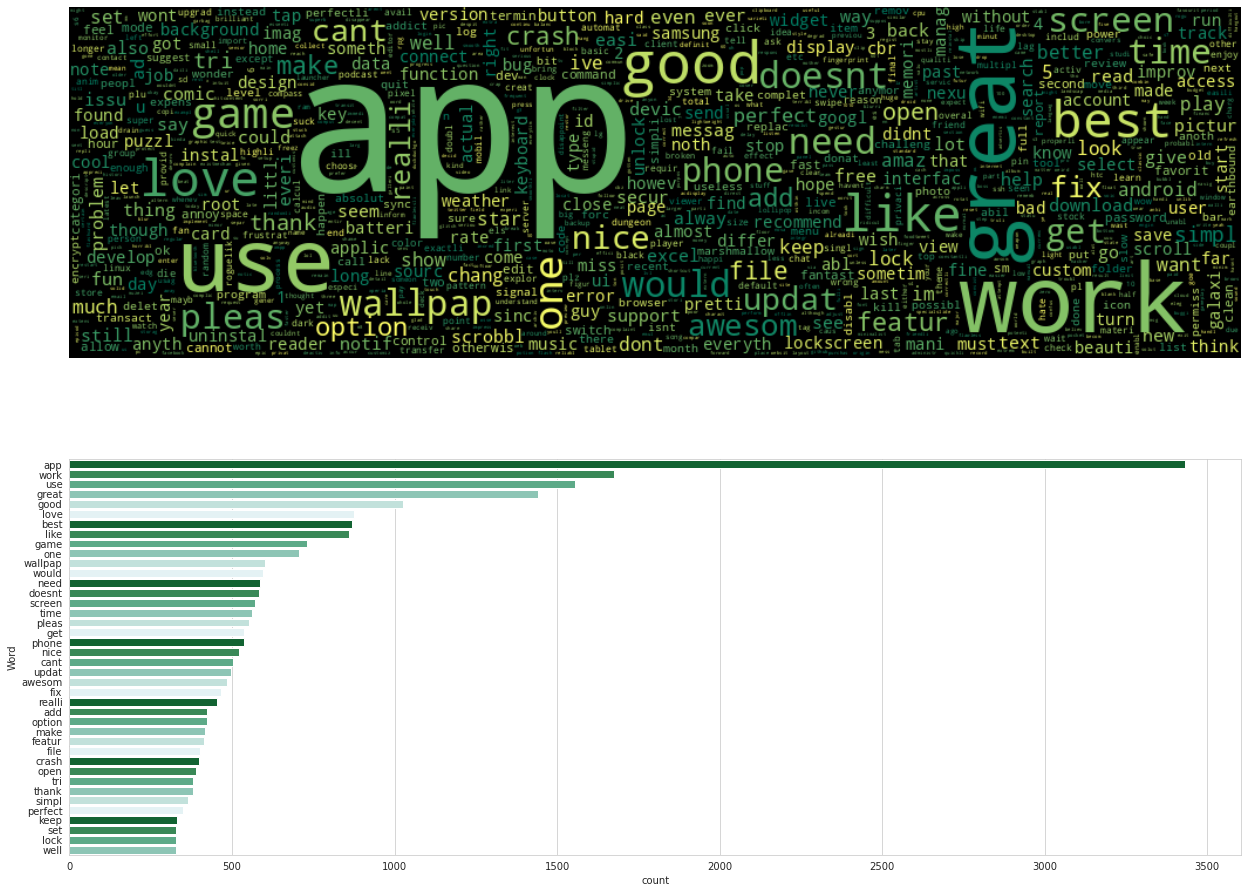

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


def word_cloud(x, terms = 40):
    all_words = ' '.join(x).split()

    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(freq_dist.keys()), 'count': list(freq_dist.values())})

    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black',
                          max_words=1628, relative_scaling=1, colormap='summer',
                          normalize_plurals=False).generate_from_frequencies(freq_dist)

    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')

    # select top 40 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms)
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()


word_cloud(dataset['reviewTextProc'])

# 1. RQ1: Classifying Reviews

To what extent does the User Request Referencer organize reviews according to meaningful maintenance and evolution tasks for developers?

### 1.1. Performance Evaluation & Plotting Functions

In [20]:
from typing import NamedTuple
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from matplotlib.axes import Axes
from matplotlib.figure import Figure


class Performance(NamedTuple):
    cat: str
    f1: float
    precision: float
    recall: float
    accuracy: float

    def print(self):
        print(f'Precision : {self.precision:.1f}%')
        print(f'Recall : {self.recall:.1f}%')
        print(f'F1-score : {self.f1:.1f}%')


def get_performance(cat: str, y_true, y_pred) -> Performance:
    """
    Evaluate model prediction performance
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1score, support = score(y_true, y_pred, pos_label=1, average='binary')

    return Performance(cat, *[round(m * 100, 1) for m in [f1score, precision, recall, accuracy]])


def performance_to_df(perf: list[Performance]) -> pd.DataFrame:
    return pd.DataFrame(classification_result_xg, columns=['Taxonomy', 'F1', 'Prec', 'Recall', 'Acc'])


def plot_classification_result(cls_res: pd.DataFrame, title: str):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)
    fig: Figure
    ax: list[Axes]

    for a in ax:
        [a.spines[k].set_visible(False) for k in ['top', 'right', 'bottom', 'left']]

    args = dict(orient='v', color='#d0ffb4', inner="quartile")
    sns.violinplot(data=cls_res[['Prec', 'Recall', 'F1']], ax=ax[0], **args)
    # sns.violinplot(data=DF(np.log10(num_issues), columns=['Issue Reports']), ax=ax[1], **args)

    ax[0].set_ylabel('Ratio or Percentage')

    plot(title=title).show()

### 1.2. Prepare train/test datasets

In [120]:
from scipy import sparse
import random
from typing import NamedTuple


all_categories = ['APP USABILITY', 'UI', 'DEVICE', 'ANDROID VERSION', 'HARDWARE', 'PERFORMANCE', 'BATTERY', 'MEMORY', 'LICENSING', 'PRICE', 'PRIVACY', 'SECURITY', 'USAGE', 'COMPATIBILITY', 'RESSOURCES', 'PRICING', 'PROTECTION', 'ERROR']
# all_categories = ['APP USABILITY', 'UI', 'DEVICE', 'ANDROID VERSION', 'HARDWARE', 'PERFORMANCE', 'BATTERY', 'MEMORY', 'LICENSING', 'PRICE', 'PRIVACY', 'SECURITY']


class TrainTestSet(NamedTuple):
    x_train: sparse.csr_matrix
    y_train: np.ndarray
    x_test: sparse.csr_matrix
    y_test: np.ndarray


tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
tfidf_vec.fit(dataset['reviewTextProc'].to_numpy())


def prepare_train_test_set(cat: str) -> TrainTestSet:
    # test_set = pd.read_csv(f'Data/RQ_1/low/{cat}_final.csv', encoding='ISO-8859-1')
    test_set = pd.read_csv(f'Data/RQ_1_mod/{cat}_final.csv', encoding='UTF-8')

    # Clean test set
    test_set['reviewTextProc'] = test_set['reviewText'].apply(preprocess)

    # exclude those reviews from label_data2 that are in test dataset (by matching ids)
    df = dataset[~dataset._id.isin(test_set._id)]

    # Delete rows with empty subclasses from dataFrame
    indexNames = df[df['subclasses'] == '[]'].index
    df.drop(indexNames , inplace=True)

    # TF-IDF transform
    x_train = tfidf_vec.transform(df['reviewTextProc'].to_numpy())
    y_train = df[f'IS_{cat}'].to_numpy()

    x_test = tfidf_vec.transform(test_set['reviewTextProc'].to_numpy())
    y_test = test_set['Actual Label'].to_numpy()  # Actual Label = 'PREDICTED_{TAXONOMY}' xor 'CORRECT'

    # Resample: Use the same number of 1s and 0s (Since there are significantly more 0s than 1s)
    num_1s = sum(y_train)
    x_0s = x_train[y_train == 0]
    x_1s = x_train[y_train == 1]
    num_0s = min(num_1s, x_0s.shape[0])

    x_0s = x_0s[random.sample(range(x_0s.shape[0]), num_0s)]
    x_train = sparse.vstack([x_0s, x_1s])
    y_train = np.array([0] * num_0s + [1] * num_1s)
    assert len(y_train) == x_train.shape[0]

    return TrainTestSet(x_train, y_train, x_test, y_test)


train_test_sets = dict(zip(all_categories, pmap(prepare_train_test_set, all_categories)))

100%|██████████| 18/18 [00:00<00:00, 28.42it/s]


### 1.4. Classification and Evaluation using XGBoost

Note: If you're using Colab, please either change runtime type to include GPU acceleration, or delete `tree_method='gpu_hist'` to use CPU computing.

To change runtime type, click the RAM DISK bars in the top right corner, and click "Change Runtime Type" in the bottom right corner of the Resources tab.

In [121]:
import xgboost


def classify_cat_xgboost(cat: str, n_estimators: int = 300) -> Performance:
    x_train, y_train, x_test, y_test = train_test_sets[cat]

    # turicreate model
    model = xgboost.XGBClassifier(tree_method='gpu_hist', n_estimators=n_estimators)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    # Performance metrics
    return get_performance(cat, y_test, pd.Series(y_pred))

classification_result_xg = smap(classify_cat_xgboost, all_categories)
print(f'Mean f1: {float(np.mean([r.f1 for r in classification_result_xg])):.1f}%')
performance_to_df(classification_result_xg)

100%|██████████| 18/18 [00:17<00:00,  1.03it/s]

Mean f1: 82.6%


,Taxonomy,F1,Prec,Recall,Acc
0,APP USABILITY,83.2,85.4,81.2,83.5
1,UI,87.6,81.0,95.5,88.0
2,DEVICE,87.2,81.5,93.8,89.0
3,ANDROID VERSION,66.7,52.0,92.9,87.0
4,HARDWARE,66.0,53.3,86.5,83.5
5,PERFORMANCE,74.8,62.9,92.4,79.5
6,BATTERY,82.9,77.3,89.5,96.5
7,MEMORY,84.0,72.4,100.0,96.0
8,LICENSING,86.3,83.0,89.8,93.0
9,PRICE,86.5,78.9,95.7,93.0


### 1.5. Choose Hyper-parameters for XGBoost

In [38]:
def choose_n_f1(n_estimators: int) -> float:
    """
    Classify all categories with a specific n_estimators value and return the mean f1 score for all
    categories
    """
    results = [classify_cat_xgboost(cat, n_estimators) for cat in ['USAGE']]
    return float(np.mean([v.f1 for v in results]))


hyper_n_x = list(range(2, 350, 50))
hyper_n_f1 = [choose_n_f1(n) for n in tq(hyper_n_x, 'Training')]

Training: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


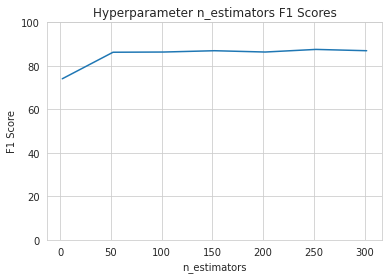

n=2   F1: 74.1
n=302 F1: 87.0


In [40]:
from pathlib import Path

plt.plot(hyper_n_x, hyper_n_f1)
plot(title='Hyperparameter n_estimators F1 Scores', ylabel='F1 Score', ylim=[0, 100], xlabel='n_estimators')
Path('fig').mkdir(exist_ok=True)
_ = plt.savefig('fig/hp_n_f1.png')
plt.show()

print(f'n={hyper_n_x[0]}   F1: {hyper_n_f1[0]:.1f}')
print(f'n={hyper_n_x[-1]} F1: {hyper_n_f1[-1]:.1f}')

In [19]:
def test_tfidf():
    hyper_tfidf_1000 = choose_n_f1(100)
    hyper_tfidf_full = choose_n_f1(100)
    print(f'TF-IDF top 1000 F1: {hyper_tfidf_1000:.1f}')
    print(f'TF-IDF top 5000 F1: {hyper_tfidf_full:.1f}')
    print(f'Percent increase: {(hyper_tfidf_full - hyper_tfidf_1000) / hyper_tfidf_1000 * 100:.1f}')


TF-IDF top 1000 F1: 55.9
TF-IDF top 5000 F1: 55.6
Percent increase: -0.5


# 2. RQ2: Source Code Localization

"Does the User Request Referencer correctly recommend the software artifacts that need to be modified in order to handle user requests and complaints?"

## 2.1. Collect Data

### 2.1.1. Find app repos by Name

(We had to manually find around half of them, since app names often change and exact matches are rare.)

In [3]:
from __future__ import annotations

import requests
import zipfile
import json
import io
import pandas
import os

from pathlib import Path


DIR_DATA = Path('Data')
DIR_RQ2 = DIR_DATA / 'RQ_2'
DIR_SOURCE = DIR_RQ2 / 'Source'
PATH_REVIEWS = DIR_DATA / 'reviews.csv'


def all_apps() -> list[str]:
    """
    Get a list of apps that appears in the reviews
    """
    df = pandas.read_csv(PATH_REVIEWS)
    return list(set(df.app))


def get_f_droid_index() -> dict[str, tuple[str, str]]:
    """
    Get F-Droid Index
    :return: {app name: source code repo}
    """
    buf = requests.get('https://f-droid.org/repo/index-v1.jar').content
    j = zipfile.ZipFile(io.BytesIO(buf)).read('index-v1.json')
    lst = json.loads(j)['apps']
    return {next(iter([lang['name'] for lang in item['localized'].values() if 'name' in lang]),
                 item['packageName']): (item['sourceCode'], item['packageName'])
            for item in lst if 'sourceCode' in item and 'localized' in item}


def find_app_repos() -> dict[str, str]:
    """
    Find apps in F-droid index
    """
    apps = all_apps()
    fdroid = get_f_droid_index()
    return {name: fdroid[name] if name in fdroid else None for name in apps}


apps = {
    'AcDisplay': ('https://github.com/AChep/AcDisplay', 'com.achep.acdisplay'),
    'Turbo Editor ( Text Editor )': ('https://github.com/vmihalachi/turbo-editor', 'com.maskyn.fileeditorpro'),
    'Signal Private Messenger': ('https://github.com/signalapp/Signal-Android', 'org.thoughtcrime.securesms'),
    'Financius - Expense Manager': ('https://github.com/mvarnagiris/financius', 'com.code44.finance'),
    'BatteryBot Battery Indicator': ('https://github.com/darshan-/Battery-Indicator-Free', 'com.darshancomputing.BatteryIndicator'),
    'Duck Duck GO': ('https://github.com/duckduckgo/Android', 'com.duckduckgo.di'),
    'Calculator': ('https://github.com/jochem88/clean-calculator', 'home.jmstudios.calc'),
    '2048': ('https://github.com/SecUSo/privacy-friendly-2048', 'org.secuso.privacyfriendly2048'),
    'Autostarts': ('https://github.com/miracle2k/android-autostarts', 'com.elsdoerfer.android.autostarts'),
    'Muzei Live Wallpaper': ('https://github.com/muzei/muzei', 'net.nurik.roman.muzei'),
    'Marine Compass': None,
    'Device Control [root]': None,
    'Twidere for Twitter': ('https://github.com/TwidereProject/Twidere-Android', 'org.mariotaku.twidere.nyan'),
    'Abstract Art': ('https://github.com/gwhiteside/abstract-art', 'net.georgewhiteside.android.abstractart'),
    'Amaze File Manager': ('https://github.com/TeamAmaze/AmazeFileManager', 'com.amaze.filemanager'),
    'Clip Stack ✓ Clipboard Manager': ('https://github.com/heruoxin/Clip-Stack', 'com.catchingnow.tinyclipboardmanager'),
    'Tweet Lanes': ('https://github.com/chrislacy/TweetLanes', 'com.tweetlanes.android'),
    'Xabber': ('https://github.com/redsolution/xabber-android', 'com.xabber.android'),
    'Bankdroid': ('https://github.com/liato/android-bankdroid', 'com.liato.bankdroid'),
    'Last.fm': ('https://github.com/lastfm/lastfm-android', 'fm.last.android'),
    'Network Log': ('https://github.com/pragma-/networklog', 'com.googlecode.networklog'),
    'OctoDroid': ('https://github.com/slapperwan/gh4a', 'com.gh4a'),
    'Wally': None,
    'CatLog': ('https://github.com/nolanlawson/Catlog', 'com.nolanlawson.logcat'),
    'ConnectBot': ('https://github.com/connectbot/connectbot', 'org.connectbot'),
    'AntennaPod': ('https://github.com/AntennaPod/AntennaPod', 'de.danoeh.antennapod'),
    'SeriesGuide': ('https://github.com/UweTrottmann/SeriesGuide/', 'com.battlelancer.seriesguide.x'),
    'OS Monitor': ('https://github.com/eolwral/OSMonitor', 'com.eolwral.osmonitor'),
    'A Comic Viewer': ('https://github.com/robotmedia/droid-comic-viewer', 'net.androidcomics.acv'),
    'AnkiDroid Flashcards': ('https://github.com/ankidroid/Anki-Android', 'com.ichi2.anki.api'),
    'Terminal Emulator for Android': ('https://github.com/jackpal/Android-Terminal-Emulator', 'jackpal.androidterm'),
    'Adblock Plus': ('https://hg.adblockplus.org/adblockplusandroid', 'org.adblockplus.android'),
    'Bubble level': None,
    'DashClock Widget': ('https://github.com/romannurik/dashclock/', 'net.nurik.roman.dashclock'),
    'Pixel Dungeon': ('https://github.com/watabou/pixel-dungeon', 'com.watabou.pixeldungeon'),
    "Simon Tatham's Puzzles": ('https://github.com/chrisboyle/sgtpuzzles', 'name.boyle.chris.sgtpuzzles'),
    'MultiPicture Live Wallpaper': None,
    'c:geo': ('https://github.com/cgeo/cgeo', 'cgeo.geocaching'),
    'QKSMS - Open Source SMS & MMS': ('https://github.com/moezbhatti/qksms', 'com.moez.QKSMS'),
}

apps_package_map = {data[1]: name for name, data in apps.items() if data is not None}

### 2.1.2. Clone Repos

In [4]:
def clone():
    for app, info in apps.items():
        if info is None:
            continue

        print(f'> Cloning {app}')
        url, pkg = info

        if 'git' not in url:
            print(f'{url} is not a git repository, please download it manually.')
            continue

        path = DIR_SOURCE / pkg
        if path.is_dir():
            print(f'{path} exists, skipping.')
            continue

        ret = os.system(f'git clone "{url}" "{path.absolute()}"')
        assert ret == 0, f'Error! Git clone exited with return code {ret}'


## 2.2. Preprocess Source Code

In [9]:
def camel_split(camel: str) -> list[str]:
    """
    Split camel case string into sentence

    Credit: https://stackoverflow.com/a/58996565/7346633

    :param camel: E.g. HelloWorld or helloWorld
    :return: E.g. ['Hello', 'World']
    """
    # Ignore all caps or all lower
    if camel.isupper() or camel.islower() or camel.isnumeric():
        return [camel]

    idx = list(map(str.isupper, camel))

    # Mark change of case
    word = [0]
    for (i, (x, y)) in enumerate(zip(idx, idx[1:])):
        if x and not y:  # "Ul"
            word.append(i)
        elif not x and y:  # "lU"
            word.append(i + 1)
    word.append(len(camel))

    # for "lUl", index of "U" will pop twice, have to filter that
    return [camel[x:y] for x, y in zip(word, word[1:]) if x < y]


# Java keywords list from https://docs.oracle.com/javase/tutorial/java/nutsandbolts/_keywords.html
java_stop_words = {
    'abstract', 'continue', 'for', 'new', 'switch',
    'assert', 'default', 'goto', 'package', 'synchronized',
    'boolean', 'do', 'if', 'private', 'this',
    'break', 'double', 'implements', 'protected', 'throw',
    'byte', 'else', 'import', 'public', 'throws',
    'case', 'enum', 'instanceof', 'return', 'transient',
    'catch', 'extends', 'int', 'short', 'try',
    'char', 'final', 'interface', 'static', 'void',
    'class', 'finally', 'long', 'strictfp', 'volatile',
    'const', 'float', 'native', 'super', 'while'
}

xml_stop_words = {
    'menu', 'item', 'uses-feature', 'uses-permission', 'application', 'activity', 'intent-filter', 'action', 'category', 'meta-data', 'android', 'label', 'parentActivityName', 'launchMode', 'windowSoftInputMode', 'receiver', 'FrameLayout', 'ImageView', 'TextView', 'LinearLayout', 'CheckBoxPreference', 'PreferenceScreen', 'RelativeLayout', 'xmlns', 'layout_width', 'layout_height', 'src', 'textColor', 'layout_marginLeft', 'layout_marginRight', 'layout_marginStart', 'layout_centerInParent', 'layout_centerHorizontal', 'layout_alignParentTop', 'layout_alignParentRight', 'layout_alignParentLeft', 'layout_alignParentBottom', 'layout_alignBaseline', 'layout_above', 'layout_below', 'layout_gravity', 'center_vertical', 'EditText', 'ScrollView', 'match_parent', 'wrap_content', 'bottom_bar', 'top_panel', '@color', '@+id', '@string', '@drawable', '@style'
}


def pre_process_file_content(ext: str, content: str) -> str:
    """
    Preprocess content of an entire file
    """
    # Collapse line breaks
    content = content.replace('\n', ' ')

    # Replace symbols with ' '
    content = ''.join([c if c not in string.punctuation else ' ' for c in content])

    # Remove multiple spaces
    while '  ' in content:
        content = content.replace('  ', ' ')

    # Camel case splitting
    word_list = [sw for w in content.split() for sw in camel_split(w)]

    # Remove stop words
    word_list = [w for w in word_list if w.lower() not in STOPWORDS]

    # Remove java stop words
    if ext.endswith('java'):
        word_list = [w for w in word_list if w not in java_stop_words]

    # Remove xml stop words
    if ext.endswith('xml'):
        word_list = [w for w in word_list if w not in xml_stop_words]

    # Stem words
    word_list = [PORTER_STEMMER.stem(w) for w in word_list]

    # Join
    content = ' '.join(word_list)

    return content


def pre_process_file(fp: Path):
    """
    Preprocess one file and write the processed content to {file_name}.proc.txt
    """
    fp.with_name(f'{fp.name}.proc.txt').write_text(pre_process_file_content(str(fp).split('.')[-1], fp.read_text('utf-8')), 'utf-8')


def pre_process_all_data(in_dir: Path):
    """
    Preprocess all files under a directory
    """
    # Find all java and xml files.
    files = [Path(dp) / f for dp, dn, filenames in os.walk(in_dir) for f in filenames
             if f.lower().endswith('.java') or f.lower().endswith('.xml')]

    # Loop through all files, preprocess them
    pmap(pre_process_file, files)


def pre_process_all_reviews(csv_path: Path):
    """
    Preprocess reviews.csv
    """
    reviews = pandas.read_csv(csv_path).to_dict('records')

    # Include only reviews for apps that have identifiable source code
    reviews = [r for r in reviews if r['app'] in apps and apps[r['app']]]

    for r in tq(reviews, 'Processing reviews'):
        # Include app package names to reviews
        r['pkg'] = apps[r['app']][1]

        # Pre-process review text
        r['reviewTextProc'] = preprocess(r['reviewText'])

    pandas.DataFrame(reviews).to_csv(csv_path.with_suffix('.processed.csv'))


print('Pre-processing all .java and .xml files and saving them to {file_name}.txt files in their directories...')
pre_process_all_data(DIR_SOURCE)
pre_process_all_reviews(PATH_REVIEWS)


Pre-processing all .java and .xml files and saving them to {file_name}.txt files in their directories...


Processing reviews: 100%|██████████| 6668/6668 [00:02<00:00, 2592.91it/s]


## 2.3 Lucene Indexing

Initially, we were using PyLucene. However, PyLucene is basically a mapping of Java interfaces to Python. It doesn't have docstring documentation, and it doesn't allow the IDE to view the original implementation. So we decided to use Lucene with Kotlin (Java) instead.

In [10]:
!which java
!java -version

/home/azalea/.conda/envs/p3/bin/java
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (Zulu 8.58.0.13-CA-linux64) (build 1.8.0_312-b07)
OpenJDK 64-Bit Server VM (Zulu 8.58.0.13-CA-linux64) (build 25.312-b07, mixed mode)


In [11]:
!cp Data/reviews.processed.csv Data/RQ_2
ret = os.system(f'java -jar P3-Replication-1.0-SNAPSHOT-all.jar "{DIR_RQ2}"')
assert ret == 0

Indexing com.achep.acdisplay...
Searching Data/RQ_2/Source/com.achep.acdisplay...
Indexing net.androidcomics.acv...
Searching Data/RQ_2/Source/net.androidcomics.acv...


## 2.4. Evaluate Source Code Localization

In [25]:
import string


def normalize_path(path: str) -> str:
    if path.startswith('/'):
        path = path[1:]

    path = path.replace('a_comic_viewer/droid-comic-viewer-master/', '')\
        .replace('acdisplay/AcDisplay-master/', '')\
        .replace('.proc.txt', '')\
        .replace('project/app/src/', 'src/').replace('src/', '').replace('main/java/', '').replace('main/', '')
    return path


def normalize_text(text: str) -> str:
    return ''.join([c for c in text.lower() if c in string.ascii_lowercase + ' '])


def evaluate_rq2():
    # Load & Normalize manual labels
    manual_labels = pandas.read_csv('Data/rq2-manual.csv').to_dict('records')
    manual_labels = {m['review_text']: m['correct_classes'] for m in manual_labels}
    manual_labels = {normalize_text(review): [normalize_path(p) for p in eval(lbl)]
                     for review, lbl in manual_labels.items()}
    Path('Data/rq2-manual-normalized.json').write_text(json.dumps(manual_labels, indent=1))

    # Load lucene search results
    search_results = [json.loads(Path(f'Data/RQ_2/Lucene/Results/{app}.json').read_text())
                      for app in ['com.achep.acdisplay', 'net.androidcomics.acv']]
    search_results = [s for app in search_results for s in app]
    search_results = {normalize_text(s['reviewText']): [normalize_path(hit['path']) for hit in s['source']]
                         for s in search_results}
    # Filter only the search results for the manually labeled reviews
    search_results = {review: search_results[review] for review in manual_labels
                      if review in search_results}
    print(f'Ignored {len(manual_labels) - len(search_results)} reviews in manual labels that are not in Lucene search results.')
    Path('Data/rq2-search-results-normalized.json').write_text(json.dumps(search_results, indent=1))

    # True positive: A source file found by Lucene is in the manual list
    # False positive: A source file found by Lucene is not in the manual list
    # True negative: A source file in the manual list is found by Lucene (Indistinguishable from True positive)
    # False negative: A source file in the manual list is not found by Lucene
    true_positive = 0
    false_positive = 0
    false_negative = 0
    ignored = 0

    # Count number of TP, FP, FN
    for review, labels in manual_labels.items():
        if review not in search_results:
            ignored += 1
            continue

        prediction = search_results[review]

        for file in prediction:
            if file in labels:
                true_positive += 1
            else:
                false_positive += 1

        for file in labels:
            if file not in prediction:
                false_negative += 1
    print(f'Number of Reviews: {len(manual_labels)}, True Pos/Neg: {true_positive}, False Positive: {false_positive}, False Negative: {false_negative}, Ignored: {ignored}')

    # Calculate score
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall != 0) else 0

    print(f"Precision: {precision * 100:.1f}%, Recall: {recall * 100:.1f}%, F1: {f1 * 100:.1f}%")


evaluate_rq2()

Ignored 0 reviews in manual labels that are not in Lucene search results.
Number of Reviews: 90, True Pos/Neg: 224, False Positive: 630, False Negative: 228, Ignored: 0
Precision: 26.2%, Recall: 49.6%, F1: 34.3%


In [33]:
def normalize_linked_class(p: str) -> str:
    p = p.replace('/a_comic_viewer/droid-comic-viewer-master/', '')\
        .replace('/acdisplay/AcDisplay-master/', '')\
        .replace('master/project/app/src/', 'src/')\
        .replace('project/app/src/', 'src/')\
        .replace('src/', '')\
        .replace('main/java/', '')\
        .replace('main/', '')\
        .replace('.proc.txt', '')

    if p.endswith('.java'):
        p = p.replace('/', '.')

    return p


def evaluate_rq2_method2():
    # Load & Normalize manual labels
    manual_labels = pandas.read_csv('Data/RQ_2/linking_data_processed.csv').to_dict('records')
    for m in manual_labels:
        m['review_text'] = normalize_text(m['review_text'])

    incorrect_map = {m['review_text']: eval(m['incorrect_classes']) for m in manual_labels}
    must_have_map = {m['review_text']: eval(m['missing_classes']) for m in manual_labels}
    reviews = list(incorrect_map.keys())
    Path('Data/rq2-manual-normalized-method2.json').write_text(json.dumps(manual_labels, indent=1))

    # Load lucene search results
    search_results = [json.loads(Path(f'Data/RQ_2/Lucene/Results/{app}.json').read_text())
                      for app in ['com.achep.acdisplay', 'net.androidcomics.acv']]
    search_results = [s for app in search_results for s in app]
    search_results = {normalize_text(s['reviewText']): [normalize_linked_class(hit['path']) for hit in s['source']]
                      for s in search_results}
    # Filter only the search results for the manually labeled reviews
    search_results = {review: search_results[review] for review in search_results}
    Path('Data/rq2-search-results-normalized-method2.json').write_text(json.dumps(search_results, indent=1))

    # True positive: A source file found by Lucene is not in the incorrect_classes list
    # False positive: A source file found by Lucene is in the incorrect_classes list
    # False negative: A source file in the must_have list is not found by Lucene
    true_positive = 0
    false_positive = 0
    false_negative = 0
    ignored = 0

    # Count number of TP, FP, FN
    for review in reviews:
        if review not in search_results:
            ignored += 1
            continue

        prediction = search_results[review]
        incorrect = incorrect_map[review]
        must_have = must_have_map[review]

        for file in prediction:
            if file not in incorrect:
                true_positive += 1
            else:
                false_positive += 1

        for file in must_have:
            if file not in prediction:
                false_negative += 1
    print(f'Number of Reviews: {len(manual_labels)}, True Pos/Neg: {true_positive}, False Positive: {false_positive}, False Negative: {false_negative}, Ignored: {ignored}')

    # Calculate score
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall != 0) else 0

    print(f"Precision: {precision * 100:.1f}%, Recall: {recall * 100:.1f}%, F1: {f1 * 100:.1f}%")


evaluate_rq2_method2()

Number of Reviews: 90, True Pos/Neg: 804, False Positive: 50, False Negative: 63, Ignored: 0
Precision: 94.1%, Recall: 92.7%, F1: 93.4%
